Работу выполнил Данил Исламов (Stepik ID: 274397404)

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

***Some parts of the notebook are almost the exact copy of***  https://github.com/yandexdataschool/nlp_course

##  Attention

Attention layer can take in the previous hidden state of the decoder $s_{t-1}$, and all of the stacked forward and backward hidden states $H$ from the encoder. The layer will output an attention vector $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far $s_{t-1}$, and all of what we have encoded $H$, to produce a vector $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode $\hat{y}_{t+1}$. The decoder input word has been embedded  $y_t$.

You can use any type of the attention scores between previous hidden state of the decoder $s_{t-1}$ and hidden state of the encoder $h \in H$, you prefer. We have met at least three of them:<br><br>

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}^{\top} \boldsymbol{s}_{t-1} & \text { dot } \\
\boldsymbol{h}^{\top} \boldsymbol{W}_{\boldsymbol{a}} \boldsymbol{s}_{t-1} & \text { general } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) & \text { concat }
\end{array}\right.$$
--------


**_We wil use "concat attention"_**:

First, we calculate the *energy* between the previous decoder hidden state $s_{t-1}$ and the encoder hidden states $H$. As our encoder hidden states $H$ are a sequence of $T$ tensors, and our previous decoder hidden state $s_{t-1}$ is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. $\Rightarrow$<br>
We have:<br>
$$H = \bigl[\boldsymbol{h}_{0}, ..., \boldsymbol{h}_{T-1}\bigr] \\ \bigl[\boldsymbol{s}_{t-1}, ..., \boldsymbol{s}_{t-1}\bigr]$$

The encoder hidden dim and the decoder hidden dim should be equal: **dec hid dim = enc hid dim**.<br>
 We then calculate the energy, $E_t$, between them by concatenating them together...<br>

$$\bigl[[\boldsymbol{h}_{0}, \boldsymbol{s}_{t-1}], ..., [\boldsymbol{h}_{T-1}, \boldsymbol{s}_{t-1}]\bigr]$$

...and passing them through a linear layer (`attn` = $\boldsymbol{W}_{\boldsymbol{a}}$) and a $\tanh$ activation function:

$$E_t = \tanh(\text{attn}(H, s_{t-1}))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[enc hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, enc hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$


We can think of this as calculating a weighted sum of the "match" over all `enc_hid_dim` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

### Temperature SoftMax

<img src="https://miro.medium.com/max/793/1*S5X1pBq_jfDreJOs7yP-ZQ.png" height=100>

This gives us the attention over the source sentence!

Graphically, this looks something like below. $z = s_{t-1}$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.


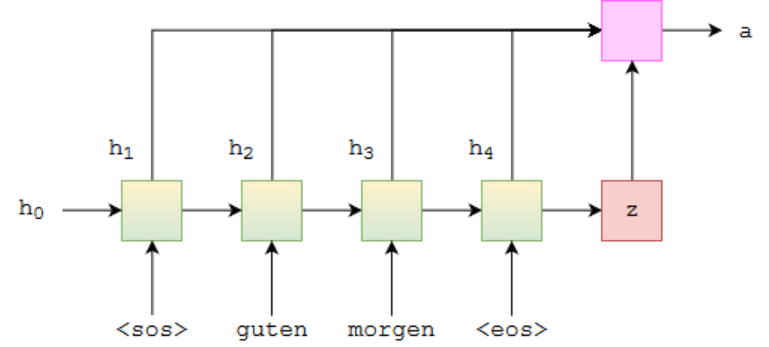

# Neural Machine Translation

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
! wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2021-04-06 19:15:44--  https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.google.com (drive.google.com)... 74.125.142.113, 74.125.142.138, 74.125.142.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k6lpia2i6bo414maclpl9gjg5v6kb9u8/1617736500000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ [following]
--2021-04-06 19:15:45--  https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k6lpia2i6bo414maclpl9gjg5v6kb9u8/1617736500000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting to doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)|108.17

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time
import numpy as np
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

We'll set the random seeds for deterministic results.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing Data

Here comes the preprocessing

In [ ]:
tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[::-1]

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize_ru,
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

TRG = Field(tokenize=tokenize_en,
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)


dataset = torchtext.legacy.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
print(len(dataset.examples))
print(dataset.examples[0].src)
print(dataset.examples[0].trg)

50000
['.', 'собора', 'троицкого', '-', 'свято', 'от', 'ходьбы', 'минутах', '3', 'в', ',', 'тбилиси', 'в', 'расположен', 'cordelia', 'отель']
['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']


In [ ]:
train_data, test_data, valid_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 7500
Number of testing examples: 2500


In [ ]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14129
Unique tokens in target (en) vocabulary: 10104


And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.'], 'src': ['.', 'услуги', 'гладильные', 'и', 'прачечной', 'услуги', ',', 'продуктов', 'доставка', 'предлагается', 'также']}


When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length; the same thing with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

## Let's use modules.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/DLS_part2/DLS_NeuralMachineTranslation

best-val-model.pt			       data.txt    __pycache__
Danil_Islamoff_NeuralMachineTranslation.ipynb  modules.py


In [ ]:
%cd /content/drive/MyDrive/DLS_part2/DLS_NeuralMachineTranslation

/content/drive/MyDrive/DLS_part2/DLS_NeuralMachineTranslation


## Encoder

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Extending our multi-layer equations to LSTMs, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

<br><br>
<img src="https://drive.google.com/uc?id=1uIUxtZU8NvGdz0J9BlRSTbsBLFh32rxx">

## Attention

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) \text { - concat attention}$$

## Decoder with Attention

To make it really work you should also change the `Decoder` class from the classwork in order to make it to use `Attention`. 
You may just copy-paste `Decoder` class and add several lines of code to it.

The decoder contains the attention layer `attention`, which takes the previous hidden state $s_{t-1}$, all of the encoder hidden states $H$, and returns the attention vector $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word that has been embedded $y_t$, the weighted source vector $w_t$, and the previous decoder hidden state $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the **first** word in an example translation.

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block is $z = s_{t-1} = s_0$, the blue block shows the decoder RNN which outputs $s_t = s_1$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$, and outputs $w_t$. The calculation of the $a_t$ is not shown.

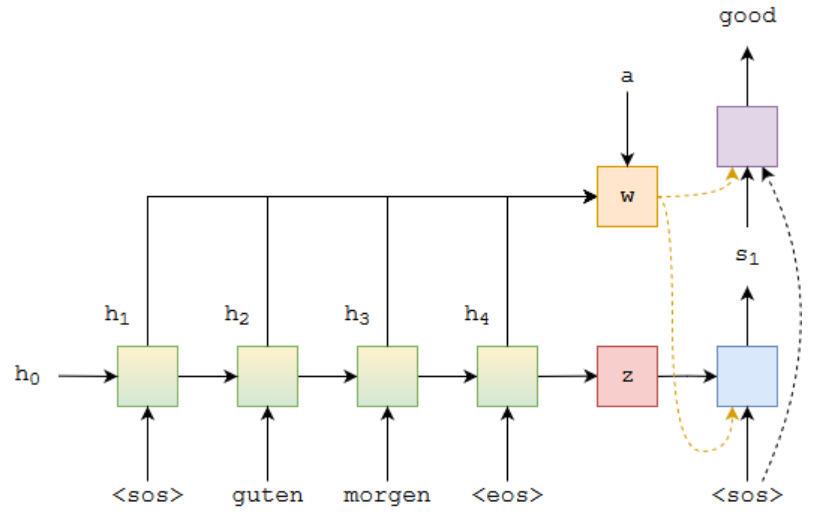

### Teacher forcing

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

<img src="https://miro.medium.com/max/421/1*U3d8D_GnfW13Y3nDgvwJSw.png">

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (i.e. real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.



## Seq2Seq

Main idea:
* $w_t = a_t H$

* $s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$

* $\hat{y}_{t+1} = f(y_t, w_t, s_t)$

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

## Training

In [ ]:
# For reloading 
import modules
import imp
imp.reload(modules)
  
Encoder = modules.Encoder
Attention = modules.Attention
Decoder = modules.DecoderWithAttention
Seq2Seq = modules.Seq2Seq

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
BIDIRECTIONAL = True
 
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)
attention = Attention(HID_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attention)

model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14129, 256)
    (rnn): LSTM(256, 256, dropout=0.25, bidirectional=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=True)
      (tanh): Tanh()
    )
    (embedding): Embedding(10104, 256)
    (rnn): GRU(768, 512, dropout=0.25)
    (out): Linear(in_features=1280, out_features=10104, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
 
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,694,009 trainable parameters


In [ ]:
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token
 
def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]
 
def generate_translation(src, trg, model, SRC_vocab, TRG_vocab):
    model.eval()
 
    output = model(src, trg, 0) #turn off teacher forcing
    output = output[1:].argmax(-1)
    
    source = remove_tech_tokens(cut_on_eos([SRC_vocab.itos[x] for x in list(src[:,0].cpu().numpy())]))
    original = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]))
    generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(output[:, 0].cpu().numpy())]))
    
    print('Source: {}'.format(' '.join(source[::-1])))
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()
 
def get_text(x, TRG_vocab):
     generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[elem] for elem in list(x)]))
     return generated

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
 
#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
 
def train(model, iterator, optimizer, criterion, clip, 
          train_history=None, valid_history=None, bleu_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, OUTPUT_DIM)
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
 
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
                ax[1].legend()
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
                ax[1].legend()
            if bleu_history is not None:
                ax[2].plot(bleu_history, label='valid bleu history')
                ax[2].set_xlabel('Epoch')
                ax[2].legend()
            
            plt.show()
 
        
    return epoch_loss / len(iterator)
 
def evaluate(model, iterator, criterion):
    original_text = []
    generated_text = []
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
 
            src = batch.src
            trg = batch.trg
            trg_bleu = trg
 
            output = model(src, trg, 0) #turn off teacher forcing
 
            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]
            
            output_bleu = output[1:].argmax(-1)
            output = output[1:].view(-1, OUTPUT_DIM)
            trg = trg[1:].view(-1)
 
            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]
 
            loss = criterion(output, trg)
            epoch_loss += loss.item()

            original_text.extend([get_text(x, TRG.vocab) for x in trg_bleu.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output_bleu.detach().cpu().numpy().T])
        
    bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
        
    return epoch_loss / len(iterator), bleu
 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

As the experiments showed, there is no clear correlation between the validation loss and the BLEU value. Moreover, the appropriate quality of translation, as well as high BLEU rate, were achieved only when the losses demonstrated that the model is very overfitted. So, we will draw the graph of BLEU values on the validation dataset over the training epochs, and determine best model parameters according to those values.

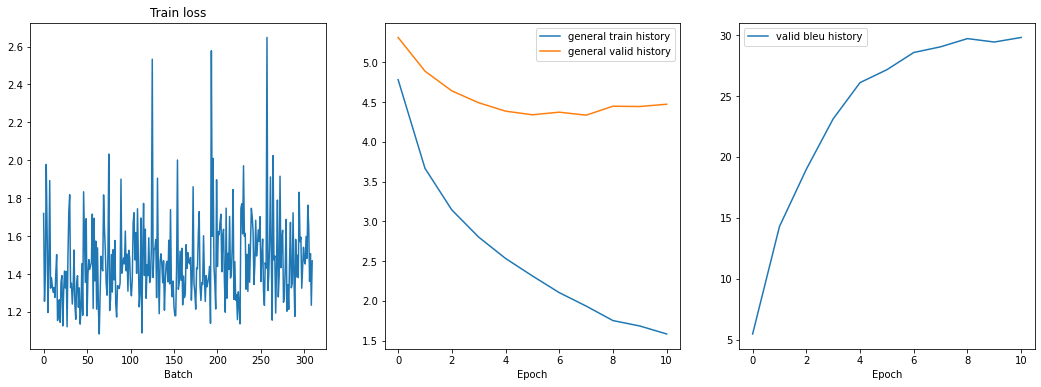

Epoch: 12 | Time: 2m 59s
	Train Loss: 1.462 | Train PPL:   4.313
	Val. Loss: 4.571 |  Val. PPL:  96.653
	Val. BLEU: 30.510


In [ ]:
train_history = []
valid_history = []
bleu_history = []
 
N_EPOCHS = 12
CLIP = 5
 
best_valid_bleu = -float('inf')
 
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history, bleu_history)
    valid_loss, valid_bleu = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_bleu > best_valid_bleu:
        best_valid_bleu = valid_bleu
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_history.append(valid_bleu)
 
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\tVal. BLEU: {valid_bleu:.3f}')

__Let's take a look at our network quality__:

In [ ]:
model.load_state_dict(torch.load('best-val-model.pt'))
batch = next(iter(test_iterator))
 
for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, SRC.vocab, TRG.vocab)

Source: также в распоряжении гостей стиральная машина .
Original: a washing machine is also provided .
Generated: a washing machine is also available .

Source: в гостиной установлен жк - телевизор .
Original: there is also a living room with an lcd tv .
Generated: the living room includes an lcd tv .

Source: предоставляются факсимильные и копировальные услуги .
Original: guests can of fax and photocopying service .
Generated: fax and photocopying services are available .

Source: собственная ванная комната укомплектована феном .
Original: the private bathroom comes with a hairdryer .
Generated: the private bathroom includes a hairdryer .

Source: также ежедневно предоставляются услуги горничной .
Original: a daily maid service is offered .
Generated: daily maid service is available .

Source: гостям предоставляются ежедневные местные газеты .
Original: daily local newspapers are also provided .
Generated: daily newspapers are available .

Source: на территории обустроена бесплатная п

## Test BLEU

[link](https://www.aclweb.org/anthology/P02-1040.pdf)

<img src="https://drive.google.com/uc?id=1umJF2S8PiayxD9Xo8xvjW8QsrSLidozD" height=400>

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():
 
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
 
        src = batch.src
        trg = batch.trg
 
        output = model(src, trg, 0) #turn off teacher forcing
 
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
 
        output = output[1:].argmax(-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])


20it [00:02,  9.29it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

31.581770049372604

## Recommendations:
* use bidirectional RNN
* change learning rate from epoch to epoch
* when classifying the word don't forget about embedding and sum of encoder's hidden state
* you can use more than one layer

## You will get:

* `2` points if `21 < bleu score < 23`
* `4` points if `23 < bleu score < 25`
* `7` points if `25 < bleu score < 27`
* `9` points if `27 < bleu score < 29`
* `10` points if `bleu score > 29`

When your result is checked, your 10 translations will be checked too


## Your Conclusion
* information about the results obtained 
* difference between seminar and homework model

As for me, the model showed quite good results, as 9 of 10 examples (see above) were translated correctly, though the model showed not so rich vocabulary as the one in the original sentences. However, there was one sentence that the model did not managed to translate properly (full stops are omitted): 

*Source: аквапарк не работает по*

*Original: the water park is closed on*

*Generated: water park is available on the water park*, 

but it should be noticed that the source sentence was not constructed correctly, what could have confused the model.

Measuring model's performance by BLEU, its score on the test dataset was 31.58. It is difficult for me to interpret this number, but, according to the [rough guideline](https://cloud.google.com/translate/automl/docs/evaluate#interpretation) from Google Cloud, BLEU between 30 and 40 can imply "Understandable to good translations" — what was seen on most of the discussed examples.

Of course, the quality of translation still leaves a lot to be desired. Maybe, there are some features exist that can help to increase the quality, or, simply, hyperparameters can be changed in some way to achieve better results, but, anyway, I think that the quality of translation was not bad, as most of the examples were understandable, correctly constructed, and addressed the meaning of the source sentence.


Considering the seminar and homework models' architectures, there were some distinctions:

1. Homework model used Attention layer (what caused several changes in the architecture of Decoder)
2. Homework model used GRU as a base RNN for the Decoder; seminar one used LSTM
3. Homework model consisted of only 1 layer; seminar one consisted of 2 layers
4. Homework model did not use dropouts in Encoder and Decoder (as there was only 1 layer in both); seminar one used dropout with probability 0.5 for both Encoder and Decoder

Also, best homework model's parameters were chosen according to the BLEU rate on the validation dataset, whereas the seminar one's were chosen by looking at the loss value on validation dataset.

In addition, it should be noticed that the validation dataset sizes were different in the seminar and homework — dataset.split takes the split ratios in the train-test-valid order, and because of this feature the sizes of validation and test parts in seminar were confused and accounted for 0.05 and 0.15 from the whole dataset respectively.

Comparison of the quality of seminar and homework models faces some difficulties — the models were tested on the different examples, and, in my opinion, the qualities of both models' translations were appropriate. If we try to refer to BLEU, there is another problem — for each model this metric was counted on the different parts of the dataset. However, if we look at the graph of BLEU on validation part in homework (that was of the same size as the test part in seminar), it can be noticed that the BLEU of homework model exceeded 30 points after 12 epochs, whereas the seminar one did not reach the level of 21. It can imply that the homework model translated some sentences more close to the original translation, than the seminar one, but still, I think that it is worth to analyze more examples in order to determine "the winner".